## Import Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

## Load Data

In [13]:
pop_df_cleaned = pd.read_csv('pop_genres_dataset.csv')
print(f"Dataset shape: {pop_df_cleaned.shape}")
pop_df_cleaned.head()

Dataset shape: (9000, 18)


,artists,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,my little airport,每次你走的時分,47,183968,0,0.576,0.505,11,-13.070,0,0.0392,0.753,0.199000,0.151,0.570,127.025,4,cantopop
1,my little airport,下了兩天雨,44,172343,0,0.577,0.228,11,-14.684,1,0.0306,0.834,0.000805,0.384,0.161,119.035,4,cantopop
2,my little airport,詩歌舞街,50,191308,0,0.641,0.479,4,-15.395,1,0.0443,0.732,0.059800,0.115,0.301,121.974,4,cantopop
3,my little airport,那陣時不知道,48,148564,0,0.613,0.210,5,-15.309,1,0.0309,0.769,0.000477,0.139,0.268,132.035,4,cantopop
4,Eason Chan,無條件,54,228973,0,0.646,0.370,0,-10.980,1,0.0351,0.825,0.000005,0.090,0.465,129.914,4,cantopop


## Explore Mode Distribution

In [14]:
pop_df_cleaned['mode'].value_counts()

mode
1    5988
0    3012
Name: count, dtype: int64

## Feature Standardization

We drop string variables and 'mode', then standardize the numerical variables to analyze coefficients.

In [15]:
pop_df_cleaned_numeric = pop_df_cleaned.select_dtypes(include='number').drop(columns=['mode', 'key'])
scaler = StandardScaler()
pop_df_cleaned_numeric_scaled = scaler.fit_transform(pop_df_cleaned_numeric)
pop_df_cleaned_numeric_scaled = pd.DataFrame(pop_df_cleaned_numeric_scaled,
                                             columns=pop_df_cleaned_numeric.columns)
pop_df_cleaned_numeric_scaled.head()

,popularity,duration_ms,explicit,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,0.165396,-0.623735,-0.195096,-0.028689,-0.559008,-1.729815,-0.370020,1.407955,1.489313,-0.215610,0.292429,0.135819,0.216434
1,0.034847,-0.769045,-0.195096,-0.021493,-1.877028,-2.239163,-0.521289,1.678715,-0.226849,1.480559,-1.529693,-0.137381,0.216434
2,0.295945,-0.531987,-0.195096,0.439056,-0.682721,-2.463541,-0.280314,1.337758,0.283986,-0.477679,-0.905984,-0.036888,0.216434
3,0.208912,-1.066276,-0.195096,0.237566,-1.962675,-2.436401,-0.516012,1.461438,-0.229689,-0.302967,-1.053001,0.307124,0.216434
4,0.470011,-0.061183,-0.195096,0.475036,-1.201364,-1.070250,-0.442136,1.648630,-0.233775,-0.659672,-0.175353,0.234602,0.216434


## Initial Logistic Regression with All Features

In [16]:
logreg_all = LogisticRegression(solver='liblinear')
logreg_all.fit(X=pop_df_cleaned_numeric_scaled,
           y=pop_df_cleaned['mode'])
print("Intercept:", logreg_all.intercept_)
print("\nCoefficients:")
for feature, coef in zip(pop_df_cleaned_numeric_scaled.columns, logreg_all.coef_[0]):
    print(f"  {feature}: {coef:.4f}")

Intercept: [0.70960767]

Coefficients:
  popularity: -0.1141
  duration_ms: -0.0643
  explicit: 0.0133
  danceability: -0.2499
  energy: -0.2124
  loudness: 0.0481
  speechiness: -0.0823
  acousticness: 0.0378
  instrumentalness: 0.0335
  liveness: -0.0204
  valence: 0.0323
  tempo: 0.0209
  time_signature: 0.0377


After scaling and standardizing the numerical variables, the two largest coefficients of the logistic regression model are danceability (-0.2499) and energy (-0.2124).

**Note:** 1 means Major key and 0 means Minor key.

Therefore, we will choose **danceability** and **energy** as the predictors for the logistic regression model.

## Split into Training and Validation Data

In [17]:
X = pop_df_cleaned_numeric_scaled[['danceability', 'energy']]
y = pop_df_cleaned['mode']
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.3,   # 30% validation, 70% train
    random_state=42, # ensures reproducibility
    stratify=y       # keeps same proportion of 0/1 in train and validation
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

Training set size: 6300
Validation set size: 2700


## Train Logistic Regression Model

In [18]:
logreg_2 = LogisticRegression(solver='liblinear')
logreg_2.fit(X=X_train, y=y_train)
print("Intercept:", logreg_2.intercept_)
print("Coefficients:", logreg_2.coef_)

Intercept: [0.70640675]
Coefficients: [[-0.25930884 -0.19584962]]


## Confusion Matrix for Training Dataset

**Confusion Matrix Format:**
```
[[TN, FP],
 [FN, TP]]
```

- **TN**: Minor predicted, Minor Actual
- **FP**: Major predicted, Minor Actual
- **FN**: Minor predicted, Major Actual
- **TP**: Major predicted, Major Actual

**Note:** The threshold value is adjusted to improve the accuracy score.

In [19]:
y_probability = logreg_2.predict_proba(X_train)[:, 1]
y_prediction = (y_probability >= 0.66).astype(int)
cm = confusion_matrix(y_train, y_prediction)
print("Confusion Matrix:")
print(cm)
print()

TN, FP, FN, TP = cm.ravel()
accuracy = (TP + TN) / (TP + TN + FP + FN)
error_rate = 1 - accuracy

print(f"Accuracy: {accuracy:.4f}")
print(f"Prediction Error: {error_rate:.4f}")

TPR = TP / (TP + FN)  # proportion of actual positives correctly predicted
print(f"True Positive Rate (Sensitivity): {TPR:.4f}")

TNR = TN / (TN + FP)  # proportion of actual negatives correctly predicted
print(f"True Negative Rate (Specificity): {TNR:.4f}")

Confusion Matrix:
[[1214  894]
 [1851 2341]]

Accuracy: 0.5643
Prediction Error: 0.4357
True Positive Rate (Sensitivity): 0.5584
True Negative Rate (Specificity): 0.5759


## ROC Curve and AUC Score

AUC Score: 0.5949


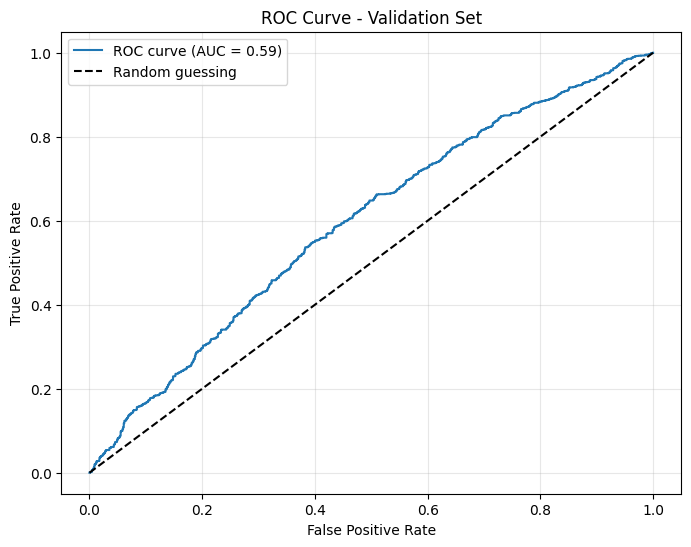

In [20]:
y_probability = logreg_2.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_probability)
auc_score = roc_auc_score(y_val, y_probability)
print(f"AUC Score: {auc_score:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guessing')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Set')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Find Optimal Threshold

To find the optimal threshold, we find the threshold where the difference between the true positive rate and the false positive rate is the greatest.

In [21]:
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.4f}")

Optimal threshold: 0.6684


## 5-Fold Cross Validation

We will keep the same logistic regression model but test it on 5 folds of the validation set.

In [22]:
skfolds = StratifiedKFold(n_splits=5)

auc_scores = []
accuracy_scores = []

i = 1
for train_index, val_index in skfolds.split(X, y):
    clone_logreg = clone(logreg_2)
    X_train_folds = X.iloc[train_index]
    y_train_folds = y.iloc[train_index]
    X_val_fold = X.iloc[val_index]
    y_val_fold = y.iloc[val_index]
    clone_logreg.fit(X_train_folds, y_train_folds)
    y_prob = clone_logreg.predict_proba(X_val_fold)[:, 1]
    y_pred = (y_prob >= 0.668).astype(int)

    auc_sample = roc_auc_score(y_val_fold, y_prob)
    acc_sample = accuracy_score(y_val_fold, y_pred)
    print(f"Fold {i}: AUC = {auc_sample:.3f}, Accuracy = {acc_sample:.3f}")

    auc_scores.append(auc_sample)
    accuracy_scores.append(acc_sample)

    i += 1

print(f"\nMean AUC: {np.mean(auc_scores):.3f}")
print(f"Mean accuracy: {np.mean(accuracy_scores):.3f}")

Fold 1: AUC = 0.633, Accuracy = 0.644
Fold 2: AUC = 0.626, Accuracy = 0.536
Fold 3: AUC = 0.547, Accuracy = 0.567
Fold 4: AUC = 0.597, Accuracy = 0.523
Fold 5: AUC = 0.556, Accuracy = 0.442

Mean AUC: 0.592
Mean accuracy: 0.543


## Summary

The data is split into 5 folds, and 5 models are trained with each fold taking its turn as the validation set. Over all 5 folds, the average AUC is ~0.592 and average accuracy is ~0.543.

**Note:** This is all using the optimal threshold found in the previous section (which may not be optimal for these folds).